# VASCULOMICS

This project consists in the development of an explainable AI algorithm to classify Brain Arteriovenous Malformations (AVM) using Arterial Spin Labelling Sequences (ASL). The used dataset is provided by Hospital Sant Joan de Déu. In this notebook this data, originally imported in a DICOM file, is separated into pathologic and healthy cases and each slice is exported as an image file to train a *DeepLearning* model.

In [3]:
import pandas as pd
import nibabel as nib
import os

VASCULOMICS database comprised 377 pediatric patients with cerebrovascular diseases, including AVM, cardiopathy, stroke, fistula, headache, sickle cell disease, Vein of Galen aneurysmal malformation, Moya Moya disease, premature and others, as well as some non-pathologic cases.  
The dataset description can be found in the following csv file:

In [4]:
df=pd.read_csv('/Users/juliaromagosa/Desktop/TFM/VASCULOMICS/Vasculomics_DB rev.csv')

In [5]:
df.head()

Unnamed: 0   Código    Fecha RM Fecha nacimiento  Dies Categories per anys  \
0     791966  VASC001  29-08-2017        10/9/1999  6534     Major de 7 anys   
1     794827  VASC002  09-12-2018        6/12/2000  6754     Major de 7 anys   
2     843708  VASC003  09-12-2019       23/11/2001  6590     Major de 7 anys   
3     887726  VASC004  09-03-2018        12/9/2000  6299     Major de 7 anys   
4     954592  VASC005  06-11-2018        5/11/2003  5658     Major de 7 anys   

  Sexo                                Descripció malaltia Disease recode  \
0    H  microaneurismas ACM y plexo venoso pontino en swi         Altres   
1    M                                     MAV con TRANCE            Mav   
2    H                           MAV con trance y 4d flow            Mav   
3    H                                  adv con cavernoma         Altres   
4    M           displasia fibrosa osea politopica cráneo         Altres   

  Maria review  ... Drenaje cerebral derecho Drenaje cerebral d recode  \
0          NaN  ...            TROLARD/LABBÉ                     MIXTO   
1           SI  ...                  TROLARD                   TROLARD   
2          NaN  ...                  TROLARD                   TROLARD   
3          NaN  ...      TROLARD/SUPERFICIAL                     MIXTO   
4          NaN  ...                  TROLARD                   TROLARD   

  Drenaje cerebral izquierdo Drenaje cerebral i recode  \
0                    TROLARD                   TROLARD   
1       SILVIANA SUPERFICIAL      SILVIANA SUPERFICIAL   
2                      LABBÉ                     LABBÉ   
3                    TROLARD                   TROLARD   
4                    TROLARD                   TROLARD   

                 Drenaje Cuello Artefactes hemorràgics HEMISFERI ASL  \
0  MIXTO (YUGULAR/NECK DRAINER)                    NaN       NaN  SÍ   
1                       YUGULAR                      p       NaN  SÍ   
2                       YUGULAR                    NaN       NaN  NO   
3                       YUGULAR                    NaN       NaN  NO   
4                       YUGULAR                    NaN       NaN  NO   

  Nom carpeta ASL       Unnamed: 30  
0             NaN               NaN  
1             NaN               NaN  
2             NaN  té ASL multifase  
3             NaN               NaN  
4             NaN               NaN  

[5 rows x 31 columns]

This data is classified and labeled according to the criteria of experts radiologists.

First we look for the patient codes which meet the following conditions:
- are diagnosed with AVM, which are the ones with disease recode "Mav"
- are labeled with the presence of accelerated vessels
- have ASL sequences on that acquisition date

We create a dataframe with this information.

In [6]:
df_MAV = df.loc[(df['Disease recode']=='Mav') & (df['ASL']=='SÍ')& (df['Accelerated vessels']=='SI')]
avm_codes=df_MAV['Código'].values
avm_codes

array(['VASC002', 'VASC023', 'VASC023', 'VASC029', 'VASC030', 'VASC033',
       'VASC033', 'VASC033', 'VASC033', 'VASC039', 'VASC060', 'VASC060',
       'VASC060', 'VASC060', 'VASC060', 'VASC074', 'VASC110', 'VASC110',
       'VASC110', 'VASC110', 'VASC173', 'VASC372', 'VASC372', 'VASC373',
       'VASC377'], dtype=object)

In [7]:
len(avm_codes)

25

As it can be seen, there are 25 cases which meet this criteria, including repeated patients, as there are different acquisition dates:

In [8]:
avm_dates=df_MAV['Fecha RM'].values
avm_dates

array(['09-12-2018', '07-01-2021', '02-02-2018', '08-04-2021',
       '07-10-2019', '25-09-2020', '10-12-2021', '13-07-2018',
       '26-09-2019', '03-09-2018', '03-05-2021', '18-07-2022',
       '11-12-2021', '07-07-2021', '20-08-2020', '26-02-2021',
       '24-12-2020', '18-11-2021', '18-12-2020', '11-12-2020',
       '06-05-2021', '29-08-2022', '12-02-2022', '06-09-2021',
       '17-06-2022'], dtype=object)

In [9]:
len(avm_dates)

25

A dataset is created for healthy patients. This includes patients:
- with disease recode "Normal"
- with ASL sequences

And also patients:
- with disease recode "Mav", but with no accelerated vessels at that acquisition date.
- ans also with ASL images

In [10]:
df_normal = df.loc[(df['Disease recode']=='Normal') &(df['ASL']=='SÍ')]
df_avm_noacc=df.loc[(df['Accelerated vessels']=='NO')&(df['Disease recode']=='Mav')]
normal_codes=df_normal['Código'].values
normal_codes_mav=df_avm_noacc['Código'].values
normal_dates=df_normal['Fecha RM'].values
normal_dates_mav=df_avm_noacc['Fecha RM'].values

In [11]:
no_avm_codes=[]
no_avm_dates=[]

for i in range(len(normal_codes)):
    no_avm_codes.append(normal_codes[i])
    no_avm_dates.append(normal_dates[i])


for i in range(len(normal_codes_mav)):
    no_avm_codes.append(normal_codes_mav[i])
    no_avm_dates.append(normal_dates_mav[i])

In [15]:
len(no_avm_codes)

41

In [16]:
len(no_avm_dates)

41

Thus, there are 41 cases considered no pathologic, without AVM detected at that time.

## Convert to nifti AVM and NO AVM

Data in DICOM file is converted to NIfTI format, to ease the preprocessing steps.

Firstly, we read the directory with the database

In [32]:
direc=[]
path_folder ='/Volumes/PeCIC_1/VASCULOMICS_DB'
for root, dirs, files in os.walk(path_folder, topdown=False):
    for name in dirs:
        if (len(name)>4) & (os.path.join(root, name).count('/')==4):
            direc.append(os.path.join(root, name))

Directory with folders of patients with AVM:

In [18]:
# directory of all path of avm patients
dirs_mav=[]
for n in range(len(direc)):
    if direc[n][32:39] in avm_codes:
        for i in range(len(avm_codes)):
            if (avm_codes[i] and avm_dates[i]) in direc[n]:
                if 'ASL'in direc[n]:
                    dirs_mav.append(direc[n])

dirs_mav.sort()

Directory with folders of patients no pathologic:

In [38]:
dirs_normal=[]
for n in range(len(direc)):
    if direc[n][32:39] in no_avm_codes:
        for i in range(len(no_avm_codes)):
            if (no_avm_codes[i] and no_avm_dates[i]) in direc[n]:
                if 'ASL'in direc[n]:
                    if direc[n] not in dirs_normal:
                        dirs_normal.append(direc[n])

dirs_normal.sort()

The *dicom2nifti* module is imported. This function converts DICOM files into nifti volumes:

In [41]:
import dicom2nifti
import scipy.ndimage as ndi
import nibabel as nib

#dicom2nifti.convert_directory(input_directory, output_directory, compression=True, reorient=True)
# -*- coding: utf-8 -*-
"""
this module houses all the code to just convert a directory of random dicom files

@author: abrys
"""
from __future__ import print_function

import dicom2nifti.patch_pydicom_encodings
import compressed_dicom



dicom2nifti.patch_pydicom_encodings.apply()

import gc
import os
import re
import traceback
import unicodedata

from pydicom.tag import Tag

import logging
import six
from future.builtins import bytes
from six import iteritems

import dicom2nifti.common as common
import dicom2nifti.convert_dicom as convert_dicom
import dicom2nifti.settings

logger = logging.getLogger(__name__)


def convert_directory(dicom_directory, output_folder, compression=True, reorient=True):
    """
    This function will order all dicom files by series and order them one by one

    :param compression: enable or disable gzip compression
    :param reorient: reorient the dicoms according to LAS orientation
    :param output_folder: folder to write the nifti files to
    :param dicom_directory: directory with dicom files
    """
    # sort dicom files by series uid
    dicom_series = {}
    for root, _, files in os.walk(dicom_directory):
        for dicom_file in files:
            file_path = os.path.join(root, dicom_file)
            # noinspection PyBroadException
            try:
                if compressed_dicom.is_dicom_file(file_path):
                    # read the dicom as fast as possible
                    # (max length for SeriesInstanceUID is 64 so defer_size 100 should be ok)

                    dicom_headers = compressed_dicom.read_file(file_path,
                                                               defer_size=100,
                                                               stop_before_pixels=False,
                                                               force=dicom2nifti.settings.pydicom_read_force)
                    if not _is_valid_imaging_dicom(dicom_headers):
                        logger.info("Skipping: %s" % file_path)
                        continue
                    logger.info("Organizing: %s" % file_path)
                    if dicom_headers.SeriesInstanceUID not in dicom_series:
                        dicom_series[dicom_headers.SeriesInstanceUID] = []
                    dicom_series[dicom_headers.SeriesInstanceUID].append(dicom_headers)
            except:  # Explicitly capturing all errors here to be able to continue processing all the rest
                logger.warning("Unable to read: %s" % file_path)
                traceback.print_exc()

    # start converting one by one
    for series_id, dicom_input in iteritems(dicom_series):
        base_filename = ""
        # noinspection PyBroadException
        try:
            # construct the filename for the nifti
            base_filename = ""
            if 'PatientName' in dicom_input[0]:
                base_filename = _remove_accents('%s' % dicom_input[0].PatientName)
                if 'AcquisitionDate' in dicom_input[0]:
                    base_filename = _remove_accents('%s_%s' % (base_filename,
                                                               dicom_input[0].AcquisitionDate))

            else:
                base_filename = _remove_accents(dicom_input[0].PatientName)
            logger.info('--------------------------------------------')
            logger.info('Start converting %s' % base_filename)
            if compression:
                nifti_file = os.path.join(output_folder, base_filename + '.nii.gz')
            else:
                nifti_file = os.path.join(output_folder, base_filename + '.nii')
            convert_dicom.dicom_array_to_nifti(dicom_input, nifti_file, reorient)
            gc.collect()
        except:  # Explicitly capturing app exceptions here to be able to continue processing
            logger.info("Unable to convert: %s" % base_filename)
            traceback.print_exc()



def _is_valid_imaging_dicom(dicom_header):
    """
    Function will do some basic checks to see if this is a valid imaging dicom
    """
    # if it is philips and multiframe dicom then we assume it is ok
    try:
        if common.is_philips([dicom_header]):
            if common.is_multiframe_dicom([dicom_header]):
                return True

        if "SeriesInstanceUID" not in dicom_header:
            return False

        if "InstanceNumber" not in dicom_header:
            return False

        if "ImageOrientationPatient" not in dicom_header or len(dicom_header.ImageOrientationPatient) < 6:
            return False

        if "ImagePositionPatient" not in dicom_header or len(dicom_header.ImagePositionPatient) < 3:
            return False

        # for all others if there is image position patient we assume it is ok
        if Tag(0x0020, 0x0037) not in dicom_header:
            return False

        return True
    except (KeyError, AttributeError):
        return False


def _remove_accents(filename):
    """
    Function that will try to remove accents from a unicode string to be used in a filename.
    input filename should be either an ascii or unicode string
    """
    # noinspection PyBroadException
    try:
        filename = filename.replace(" ", "_")
        if isinstance(filename, type(six.u(''))):
            unicode_filename = filename
        else:
            unicode_filename = six.u(filename)
        cleaned_filename = unicodedata.normalize('NFKD', unicode_filename).encode('ASCII', 'ignore').decode('ASCII')

        cleaned_filename = re.sub('[^\w\s-]', '', cleaned_filename.strip().lower())
        cleaned_filename = re.sub('[-\s]+', '-', cleaned_filename)

        return cleaned_filename
    except:
        traceback.print_exc()
        return filename


def _remove_accents_(filename):
    """
    Function that will try to remove accents from a unicode string to be used in a filename.
    input filename should be either an ascii or unicode string
    """
    if isinstance(filename, type(six.u(''))):
        unicode_filename = filename
    else:
        unicode_filename = six.u(filename)
    valid_characters = bytes(b'-_.() 1234567890abcdefghijklmnopqrstuvwxyz')
    cleaned_filename = unicodedata.normalize('NFKD', unicode_filename).encode('ASCII', 'ignore')

    new_filename = six.u('')

    for char_int in bytes(cleaned_filename):
        char_byte = bytes([char_int])
        if char_byte in valid_characters:
            new_filename += char_byte.decode()

    return new_filename

The directories defined previously are converted into nifti files in two specified output directorie:

**AVM**

In [44]:
avm_directory='/Users/juliaromagosa/Desktop/TFM/VASCULOMICS/img/nifti_avm'
for dirs in dirs_mav:
    convert_directory(dirs, avm_directory, compression=True, reorient=True)   

**Healthy, no AVM**

In [45]:
no_avm_directory='/Users/juliaromagosa/Desktop/TFM/VASCULOMICS/img/nifti_no_avm'
for dirs in dirs_normal:
    convert_directory(dirs, no_avm_directory, compression=True, reorient=True)   

# AVM nifti images

Separately, the nifti images can be loaded and we create a list of the files in the directory with nifti AVM volumes

In [46]:
import os
avm_directory='/Users/juliaromagosa/Desktop/TFM/VASCULOMICS/img/nifti_avm'
volumes_avm=[]
for root, dirs, files in os.walk(avm_directory, topdown=False):
    for file in files:
        if '.DS_Store' not in file:
            volumes_avm.append(os.path.join(root, file))

Following, we can observe some examples of the slices of volumes with AVM. Volumes are normalized between 0 and 255 and are plotted without filters

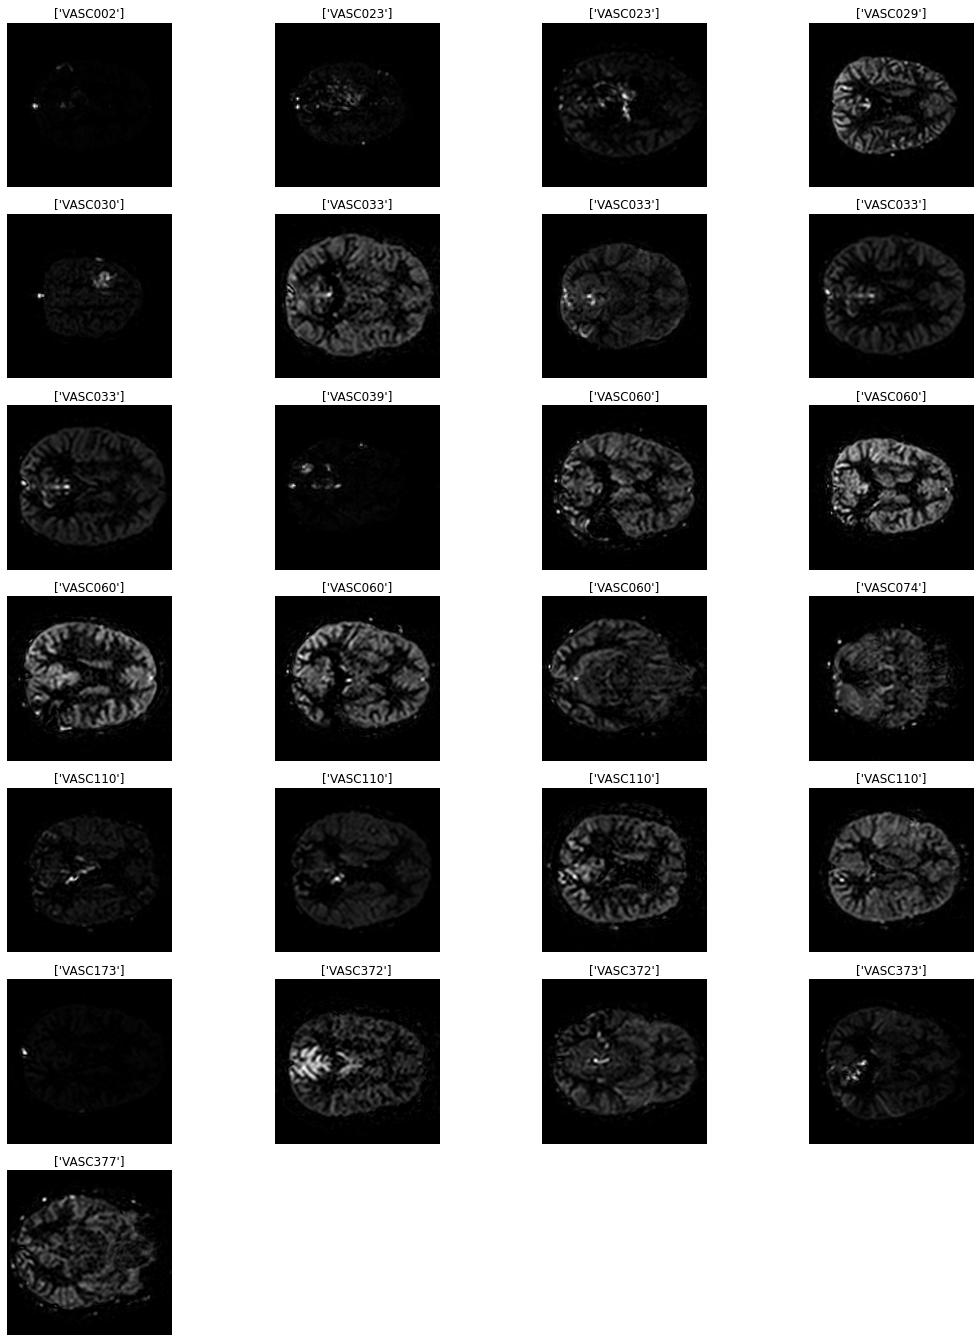

In [73]:
# save all volumes in a list, normalize them between 0 and 255, resize and plot them without filters
from skimage.exposure import equalize_adapthist,equalize_hist
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
fig = plt.figure(figsize=(15, 40))
cnt=0
volumes_avm.sort()
volumes_avm_norm=[]
for i in range(len(volumes_avm)):
    cnt += 1
    vol=nib.load(volumes_avm[i]).get_fdata()
    norm = cv2.normalize(vol, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F) 
    im=cv2.resize(norm,(176,176))
    volumes_avm_norm.append(im)
    ax = fig.add_subplot(15,4,cnt)
    ax.imshow(norm[:,:,9], cmap='gray')
    ax.set_title(['{}'.format(avm_codes[i])])
    ax.axis('off')

fig.tight_layout()

All the slices can be stacked as a total volume:

In [81]:
volumes_avm_reshape=[]
for i in range(len(volumes_avm_norm)):
    for s in range(volumes_avm_norm[i].shape[2]):
        im=volumes_avm_norm[i][:,:,s]
        volumes_avm_reshape.append(im)
        
volumes_avm_reshape=np.stack(volumes_avm_reshape)

In [80]:
volumes_avm_reshape.shape

(503, 176, 176)

## Match  histograms 

Most of the images have different grayscale intensities. We can equalize images according to reference histogram of whole volume using the function *match_histograms*. With this function we create a reference histogram of the volume of all AVM slices, *volumes_avm_reshape*, and we match each slice histogram of according to this reference.

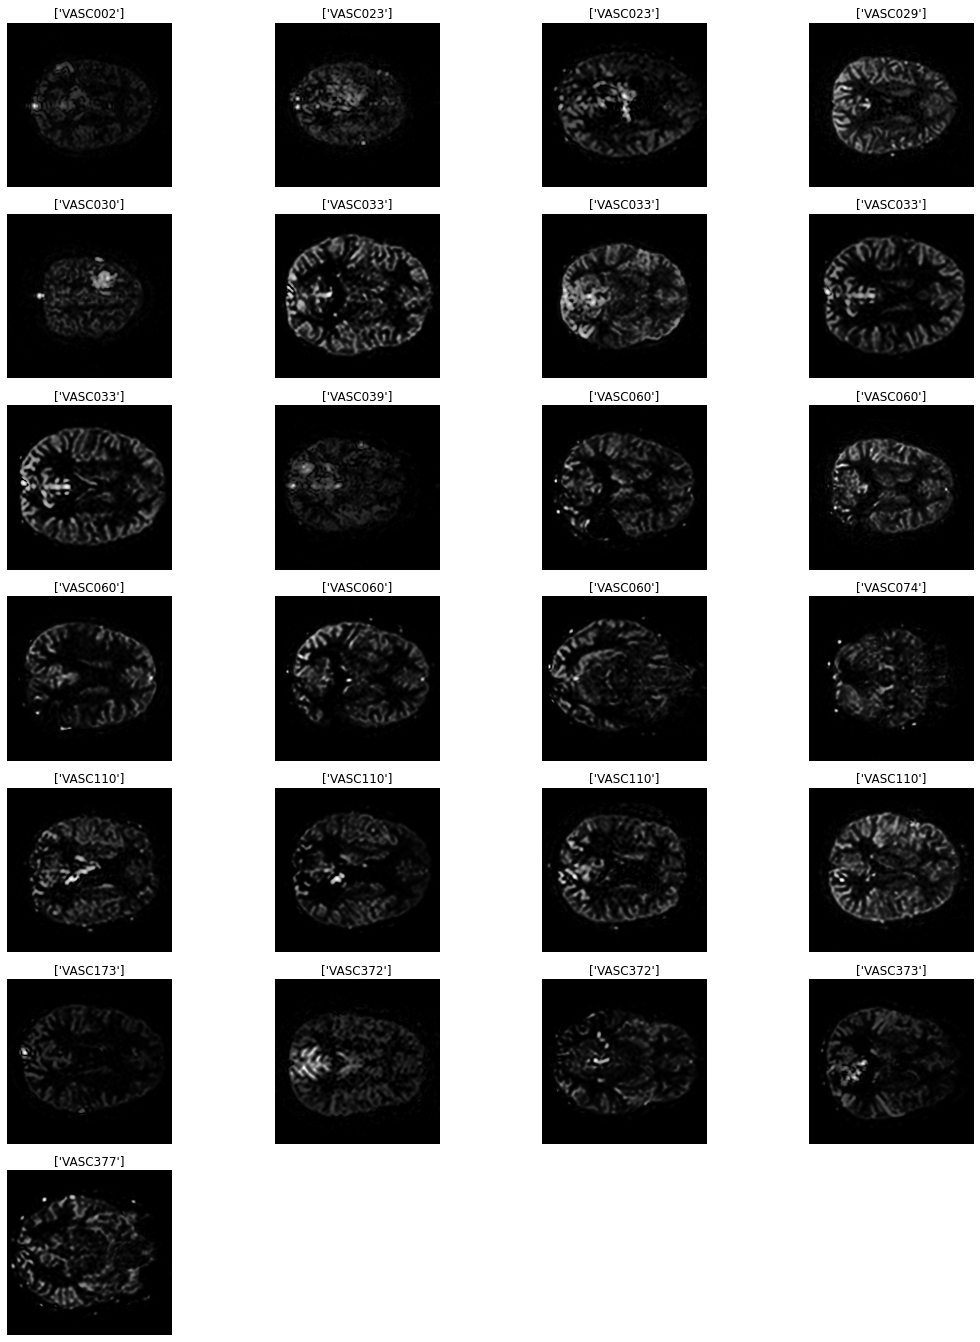

In [84]:
# match all histograms with this reference
from skimage.exposure import match_histograms
fig = plt.figure(figsize=(15, 40))

matched_data_avm=[]
cnt=0
for i in range(len(volumes_avm_norm)):
    matched = match_histograms(volumes_avm_norm[i], volumes_avm_reshape)
    matched_data_avm.append(matched)
    cnt += 1
    ax = fig.add_subplot(15,4,cnt)
    ax.set_title(['{}'.format(avm_codes[i])])
    ax.imshow(matched[:,:,9],cmap='gray')
    ax.axis('off')

fig.tight_layout()

## Otsu

Not in all slices the malformation can be observed. AVM are detected in ASL images as high signal intensities, clearly differentiated from other regions and which can also be large or just an abnormal high intensity point with continuation in previous or posterior slices.

An otsu threshold can be use to binarize images and detect this abnormal high intensities.

(-0.5, 175.5, 175.5, -0.5)

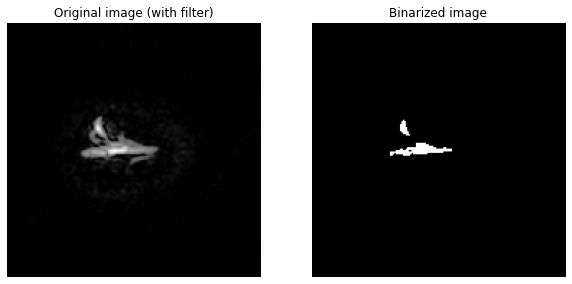

In [196]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(volumes_avm_reshape)
binary = volumes_avm_norm[0] > thresh

fig,ax=plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(matched_data_avm[0][:,:,18],cmap='gray')
ax[0].set_title('Original image (with filter)')
ax[0].axis('off')
ax[1].imshow(binary[:,:,18],cmap='gray')
ax[1].set_title('Binarized image')
ax[1].axis('off')


In [195]:
number_of_white_pix = np.sum(binary[:,:,18] == 1)
number_of_black_pix = np.sum(binary[:,:,18] == 0)
perc=(number_of_white_pix/(number_of_black_pix+number_of_white_pix))*100
print(f'number_of_black_pix:{number_of_black_pix}')
print(f'number_of_white_pix:{number_of_white_pix}')
print(f'percentage of white:{perc}')

number_of_black_pix:30745
number_of_white_pix:231
percentage of white:0.7457386363636364


We can create an approximation where if the percentage of white pixels is superior to a threshold, this slice is labeled as pathologic.

In [220]:
# slices pathologic 
thresh_avm = threshold_otsu(volumes_avm_reshape)

n_slicepat={}

slices=[]
for n in range(len(volumes_avm_norm)):
    binary = volumes_avm_norm[n] > thresh_avm
    lista=[]
    for i in range(binary.shape[2]): 
        number_of_white_pix = np.sum(binary[:,:,i] == 1)
        number_of_black_pix = np.sum(binary[:,:,i] == 0)
        perc=(number_of_white_pix/(number_of_black_pix+number_of_white_pix))*100
        if perc>0.45:
                lista.append(i)
                n_slicepat[n]=lista
            
n_slicepat

{0: [2, 3, 4, 9, 10, 12, 13, 14, 15, 16, 18],
 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 4: [7, 8, 9, 10, 11, 12],
 5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 9: [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 11: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 12: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 13: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 14: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 16: 

Above we have a list of the pathologic slices of each volume

## Save slices as npy files

This slices can be exported as separate images in a npy format, which compresses all this data.

In [ ]:
avm_filter=[]
for i in range(len(matched_data_avm)):
    for n in range(len(n_slicepat[i])):
        image=matched_data_avm[i][:,:,n_slicepat[i][n]]
        image=cv2.resize(image,(320,320))
        avm_filter.append(image)

print(f'Number of avm images: {len(avm_filter)}')   

In [228]:
# directly load npy images from folder
avm_images_path='/Users/juliaromagosa/Desktop/TFM/VASCULOMICS/img/npy/npy_avm.npy'
images_avm = np.load(avm_images_path)
print(f'Number of avm images: {len(images_avm)}')

Number of avm images: 387


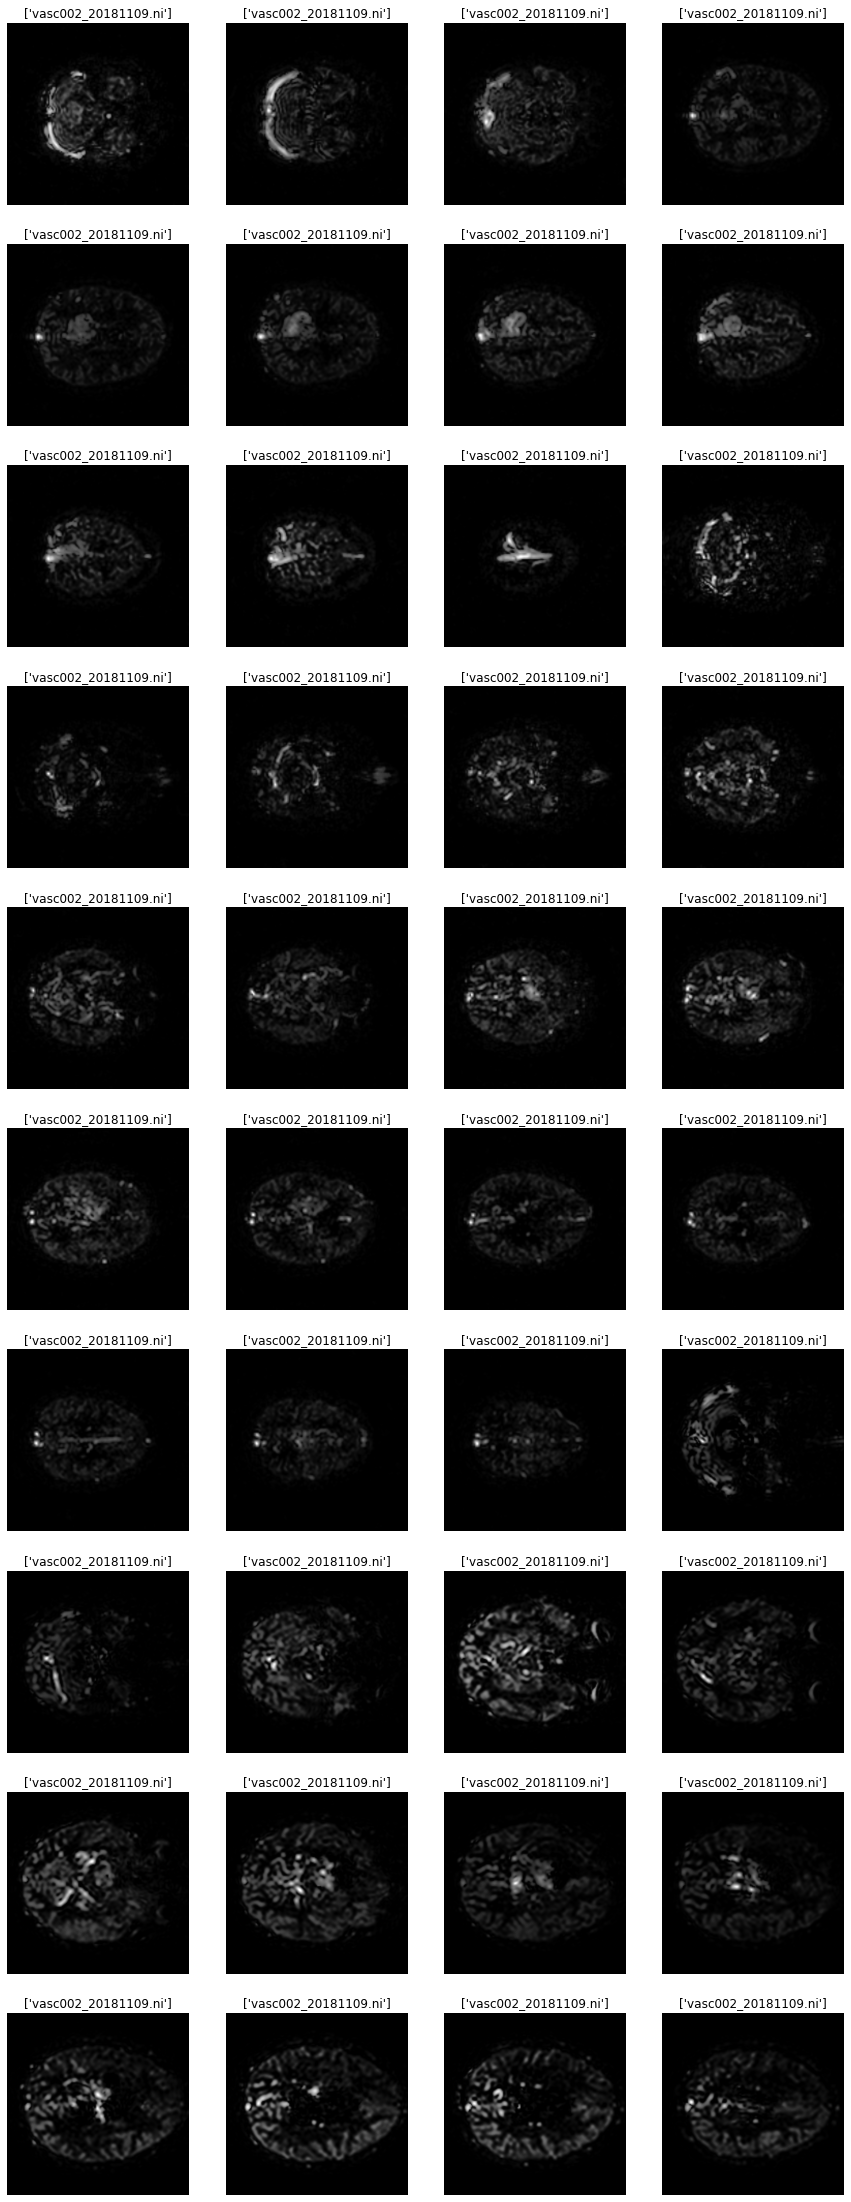

In [243]:
# show some npy images of avm patients
fig = plt.figure(figsize=(15, 40))
cnt=0
for i in range(0,40):
    cnt += 1
    ax = fig.add_subplot(10,4,cnt)
    ax.set_title(['{}'.format(volumes_avm[0][59:-4])])
    ax.imshow(images_avm[i],cmap='gray')
    ax.axis('off')

# Normal nifti images

The nifti healthy files are loaded and we create a list of the files in the directory.

In [12]:
import os
volumes_normal=[]
no_avm_directory='/Users/juliaromagosa/Desktop/TFM/VASCULOMICS/img/nifti_no_avm'
for root, dirs, files in os.walk(no_avm_directory, topdown=False):
    for file in files:
        if '.DS_Store' not in file:
            volumes_normal.append(os.path.join(root, file))

Volumes are loaded and normalizes, and finally saved on a list.

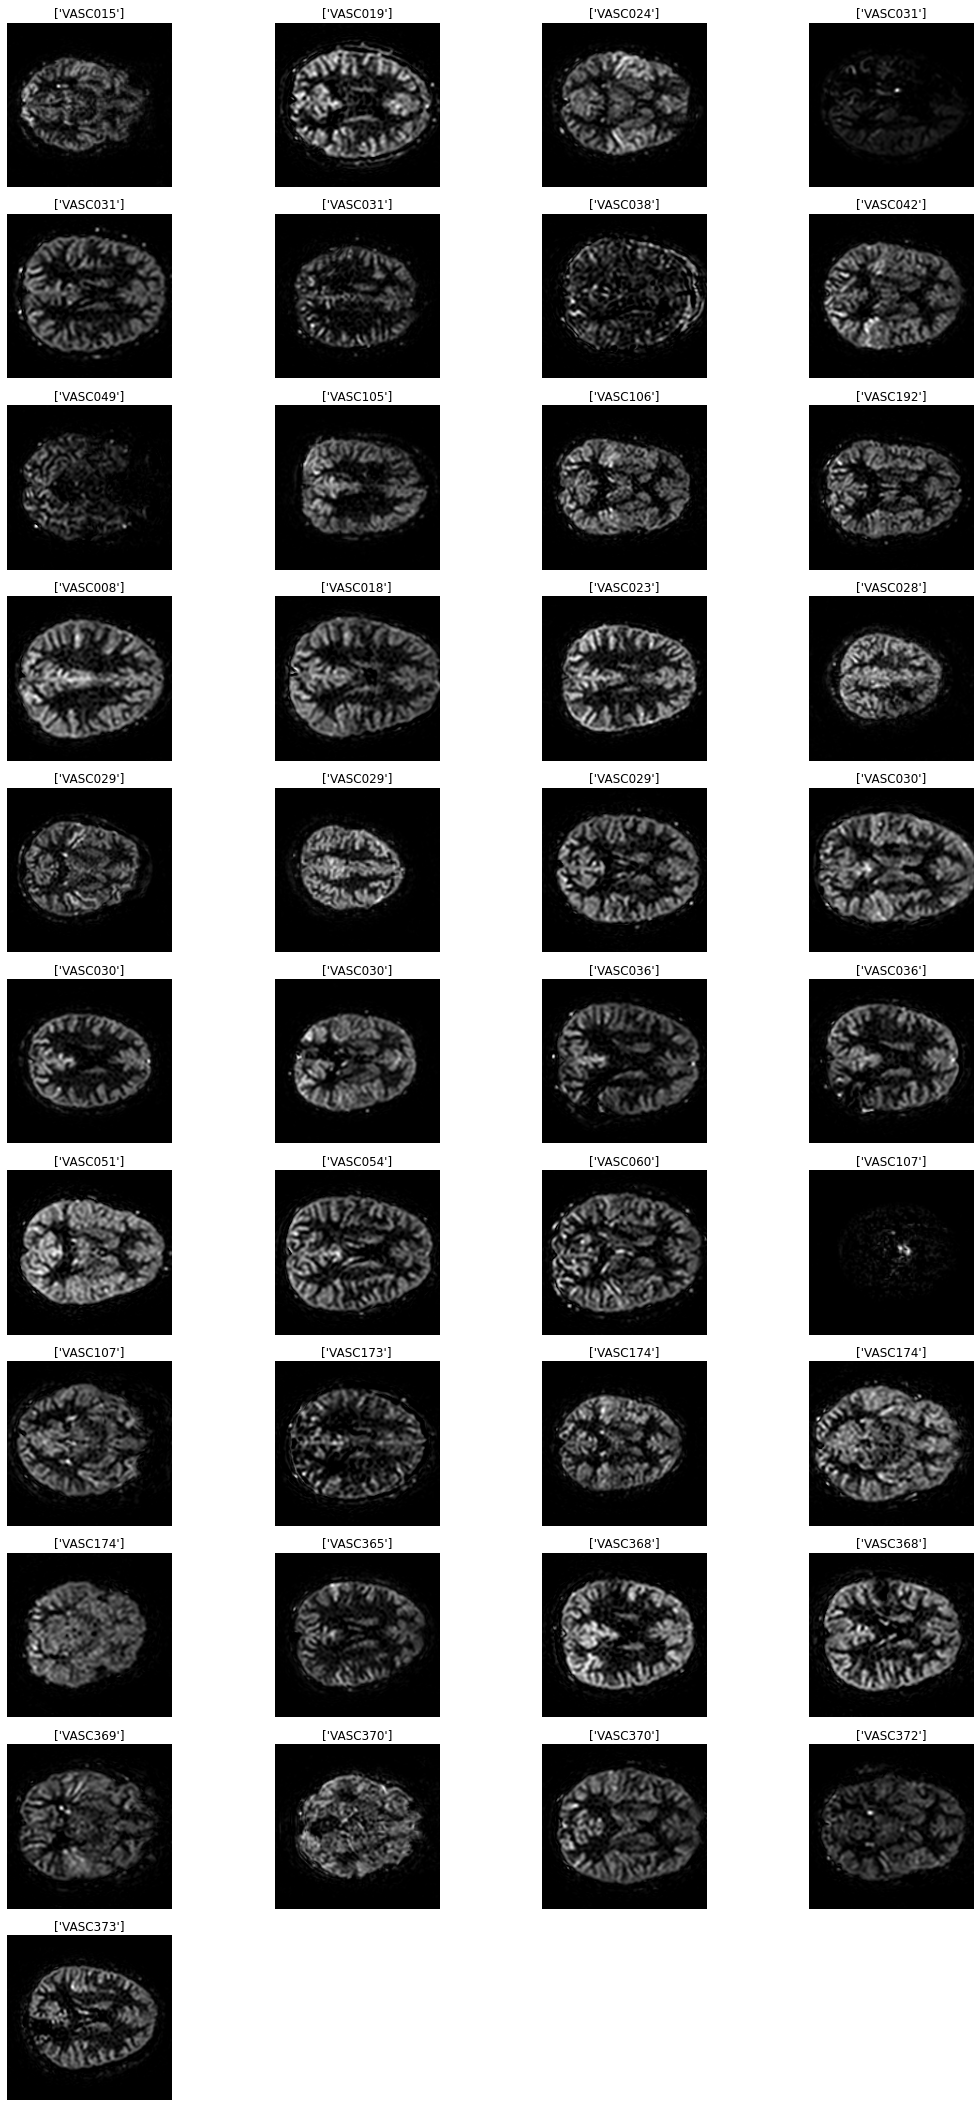

In [13]:
# save all volumes in a list, normalize them between 0 and 255 and plot them without filters
from skimage.exposure import equalize_adapthist,equalize_hist
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
fig = plt.figure(figsize=(15, 40))
cnt=0
volumes_normal.sort()
volumes_normal_norm=[]
for i in range(len(volumes_normal)):
    cnt += 1
    vol=nib.load(volumes_normal[i]).get_fdata()
    norm = cv2.normalize(vol, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F) 
    im=cv2.resize(norm,(176,176))
    volumes_normal_norm.append(im)
    ax = fig.add_subplot(15,4,cnt)
    ax.imshow(im[:,:,9], cmap='gray')
    ax.set_title(['{}'.format(no_avm_codes[i])])
    ax.axis('off')

fig.tight_layout()

In [14]:
volumes_normal_reshape=[]
for i in range(len(volumes_normal_norm)):
    for s in range(volumes_normal_norm[i].shape[2]):
        im=volumes_normal_norm[i][:,:,s]
        volumes_normal_reshape.append(im)
        
volumes_normal_reshape=np.stack(volumes_normal_reshape)

The list of volumes can be stacked, forming a huge volume containing all the slices.

## Match  histograms 

Following the same procedure that in AVM images, we equalize slices according to reference histogram of whole volume:

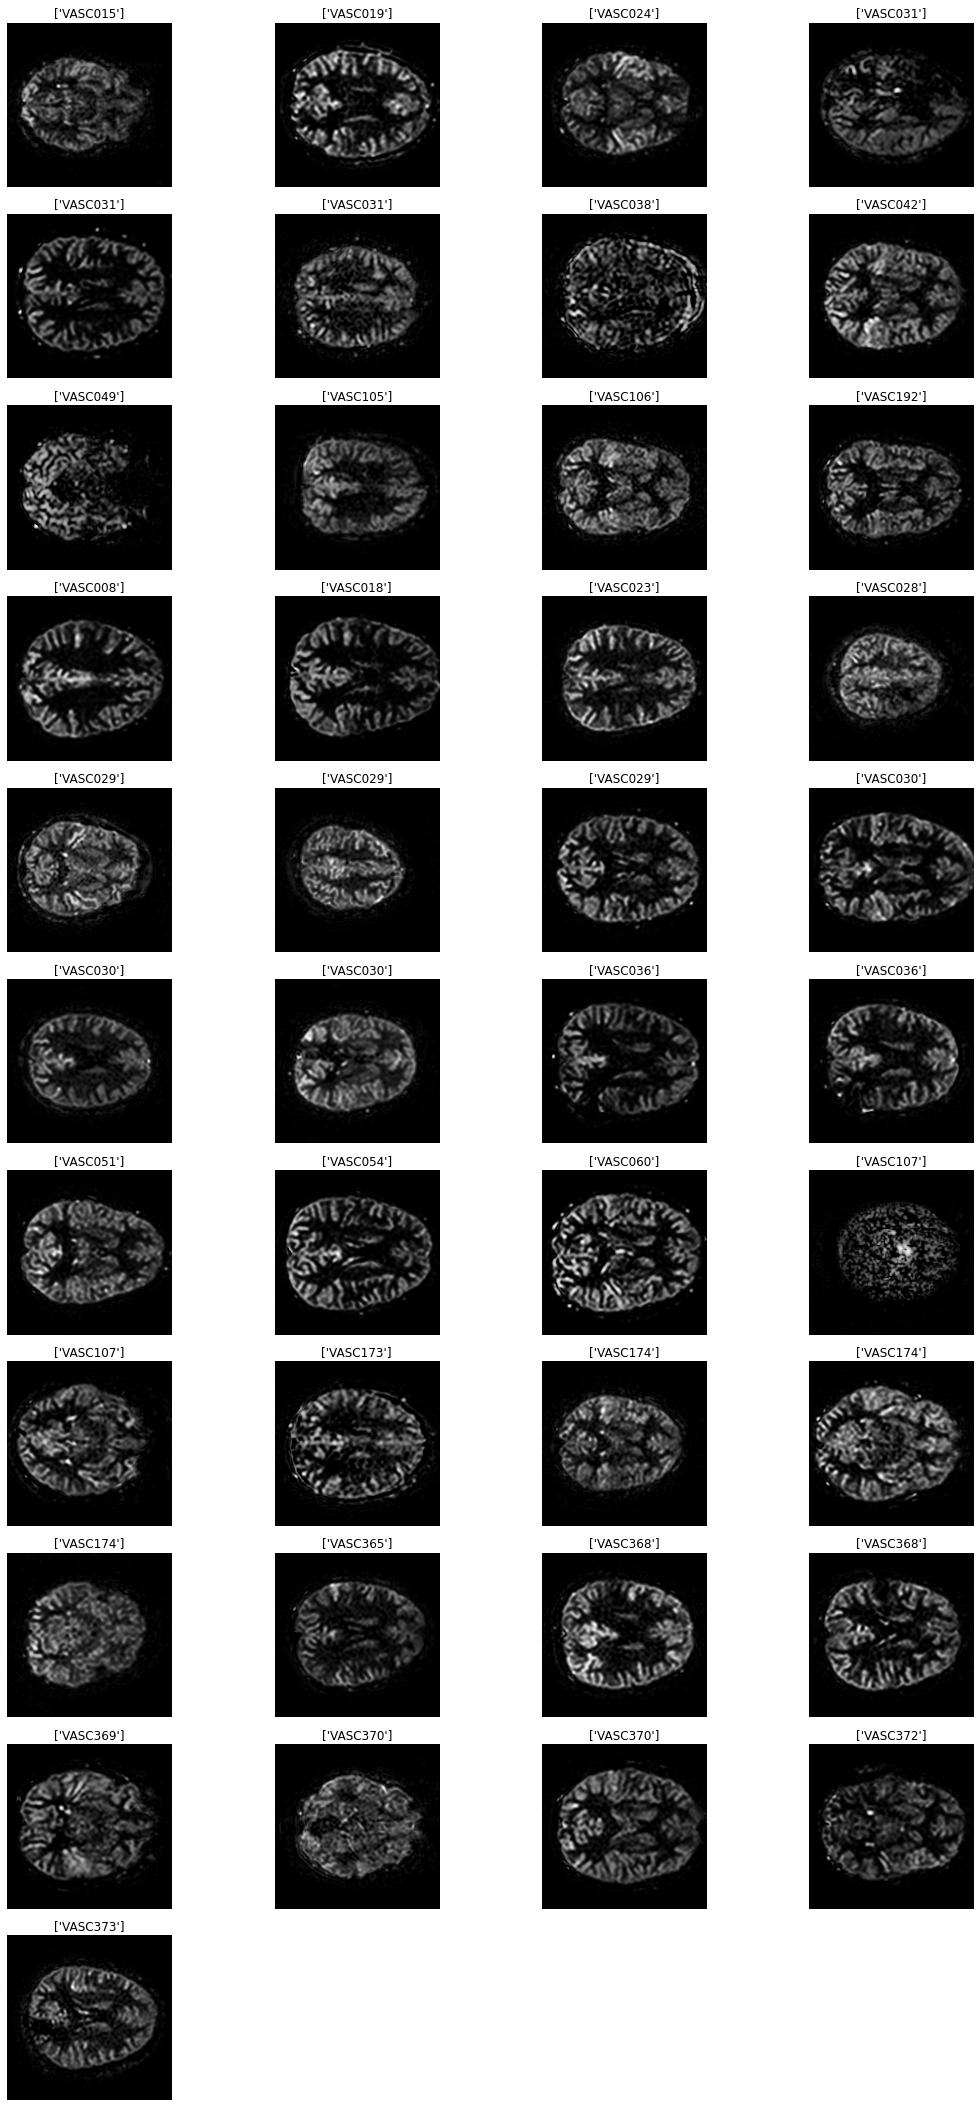

In [15]:
# match all histograms with this reference
from skimage.exposure import match_histograms
fig = plt.figure(figsize=(15, 40))

matched_data_normal=[]
cnt=0
for i in range(len(volumes_normal_norm)):
    matched = match_histograms(volumes_normal_norm[i], volumes_normal_reshape)
    matched_data_normal.append(matched)
    cnt += 1
    ax = fig.add_subplot(15,4,cnt)
    ax.set_title(['{}'.format(no_avm_codes[i])])
    ax.imshow(matched[:,:,9],cmap='gray')
    ax.axis('off')
    

fig.tight_layout()

It is observed that there is one image with artifacts which was not previously detected.
This image is removed:

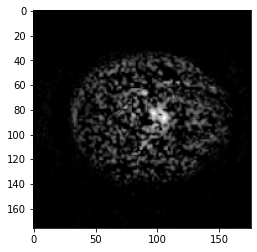

In [16]:
plt.imshow(matched_data_normal[27][:,:,9],cmap='gray')

In [19]:
del matched_data_normal[27]

## Save slices as npy files

Each slice preprocessed is saved as a separate image. We discard the first and last 3 slices as they do not contain relevant information.

In [30]:
range(int(matched_data_normal[1].shape[2]/6),matched_data_normal[1].shape[2]-int(matched_data_normal[1].shape[2]/8))

range(3, 18)

In [28]:
#uncomment to save
normal_filter=[]
for i in range(len(matched_data_normal)):
    for n in range(int(matched_data_normal[i].shape[2]/5),matched_data_normal[i].shape[2]-int(matched_data_normal[i].shape[2]/6)):
        image=matched_data_normal[i][:,:,n]
        image=cv2.resize(image,(320,320)) 
        normal_filter.append(image)
len(normal_filter)

545

In [29]:
normal_images_path='/Users/juliaromagosa/Desktop/TFM/VASCULOMICS/img/npy/'
normal_filter=np.stack(normal_filter)
np.save(normal_images_path+'npy_normal.npy',normal_filter)

Load npy files:

In [31]:
# directly load npy images from folder
normal_images_path='/Users/juliaromagosa/Desktop/TFM/VASCULOMICS/img/npy/npy_normal.npy'
images_normal = np.array(np.load(normal_images_path))
print(f'Number of normal images: {len(images_normal)}')

Number of normal images: 545


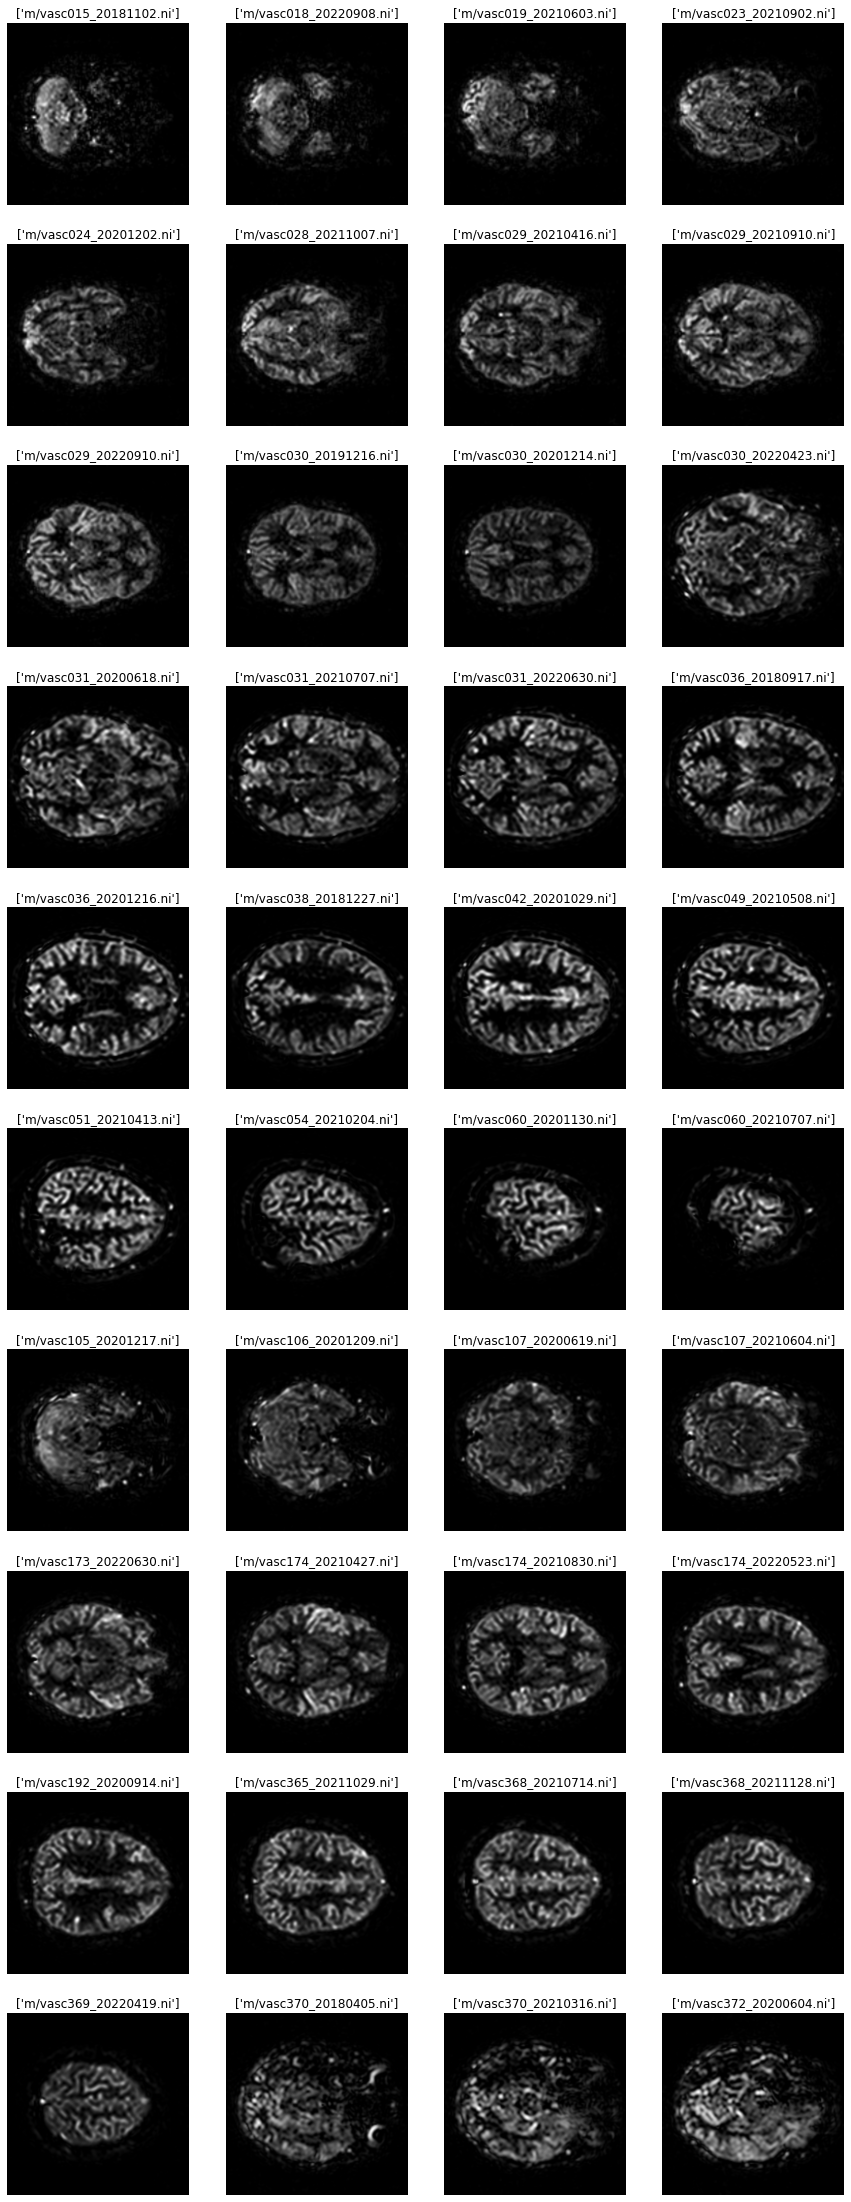

In [32]:
# show some npy images of normal patients
fig = plt.figure(figsize=(15, 40))
cnt=0
for i in range(0,40):
    cnt += 1
    ax = fig.add_subplot(10,4,cnt)
    ax.set_title(['{}'.format(volumes_normal[i][62:-4])])
    ax.imshow(images_normal[i],cmap='gray')
    ax.axis('off')
